In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from scipy.optimize import fsolve, root, bisect

sns.set_style('whitegrid')

!nvidia-smi

Thu Apr  4 13:20:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   26C    P0              57W / 400W |  30778MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-10, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if abs(f(x_next)) < abs_tol:
            return x_next
        x = x_next
    return None

def solve_kappa(q, lamb, etaX, upper_bound=None, anneal_steps=0):
  if not upper_bound:
    upper_bound = lamb + 1e3
  if lamb == 0:
    if q < 1:
      return 0
    else:
      fn = lambda kappa: 1 - q * df_1(etaX, kappa)
      return newton(fn, x0=upper_bound)
  if anneal_steps:
    anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps)[::-1]
    kappa = upper_bound
    for anneal_lamb in anneal_schedule:
      fn = lambda kappa: kappa * (1 - q * df_1(etaX, kappa)) - anneal_lamb
      kappa_next = newton(fn, x0=kappa)
      if not kappa: 
        print("Annealing didn't find kappa. Returning last value.")
        return kappa
      kappa = kappa_next
    return kappa
  else:
    fn = lambda kappa: kappa * (1 - q * df_1(etaX, kappa)) - lamb
    return newton(fn, x0=upper_bound)

def estimate_S(q,lamb, X_tr, hat_op):
  P = X_tr.shape[0]
  if q >= 1:
    return (lamb*jnp.trace(jnp.linalg.inv(X_tr @ X_tr.T + P*lamb*np.identity(P))))**(-1)
  else:
    return 1/(1-jnp.trace(hat_op @ X_tr) / P)  

In [3]:
def simulate_theory(D, qs, lambs, sigma_epsilon, spectrum, teacher, X_te, y_te, num_X_seeds):
    if type(lambs) != list:
        lambs = [lambs]*len(qs)
    data = {}
    S = jnp.diag(spectrum)
    w = teacher
    for i in tqdm(range(len(qs))):
        q, lamb  = qs[i], lambs[i]
        P = int(D/q)
        y_hats = np.zeros((num_X_seeds, X_te.shape[0]))
        y_hats_clean = np.zeros((num_X_seeds, X_te.shape[0]))
        df1_empirical = np.zeros(num_X_seeds)
        kappa_GCV = np.zeros(num_X_seeds)
        Etrs = np.zeros(num_X_seeds)
        for X_seed in range(num_X_seeds):
            key = random.PRNGKey(X_seed)
            X_tr_key, e_key = random.split(key)

            epsilon = random.normal(e_key, (P, )) * sigma_epsilon
            X_tr = random.normal(X_tr_key, (P, D)) @ (S**0.5)
            y_tr = X_tr @ w + epsilon
            y_tr_clean = X_tr @ w

            if 0.8 < P/D < 1.2:
                hat_op = jnp.linalg.pinv(X_tr.T @ X_tr + P*lamb*np.identity(D)) @ X_tr.T
            if P > D:
                hat_op = jnp.linalg.inv(X_tr.T @ X_tr + P*lamb*np.identity(D)) @ X_tr.T
            else: 
                hat_op = X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T + P*lamb*np.identity(P))
            w_star = hat_op @ y_tr
            w_star_clean = hat_op @ y_tr_clean

            y_hat_te = X_te @ w_star
            y_hat_te_clean = X_te @ w_star_clean
            y_hats[X_seed, :] = y_hat_te
            y_hats_clean[X_seed, :] = y_hat_te_clean

            if P >= D:
                y_hat_tr = X_tr @ w_star
                E_tr = jnp.mean((y_tr - y_hat_tr)**2).item()
            else:
                E_tr = lamb**2/P * jnp.linalg.norm((jnp.linalg.inv(X_tr @ X_tr.T/P + lamb*np.identity(P))) @ y_tr)**2
            Etrs[X_seed] = E_tr
            df1_empirical[X_seed] =jnp.trace(hat_op @ X_tr) / D
            kappa_GCV[X_seed] = lamb * estimate_S(q, lamb, X_tr, hat_op)

            
        Eg = np.mean((y_hats - y_te[None, :])**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_te[None, :])**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        Bias = np.mean((y_te - np.mean(y_hats_clean, axis=0))**2)
        VarX = np.mean((y_hats_clean - y_te)**2, axis=-1) - Bias
        VarXe = Noise
        data[q] = {
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': Noise,
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1': np.mean(df1_empirical),
            'df1_std': np.std(df1_empirical),
            'kappa_GCV': np.mean(kappa_GCV),
            'kappa_GCV_std': np.std(kappa_GCV)
        }
        data[q]

    dataT = {}
    for key in data[qs[0]]:
        dataT[key] = np.array([data[q][key] for q in data])
    return dataT
    

def solve_theory(qs, lambs, sigma_epsilon, spectrum, teacher, anneal_steps=0):
    if type(lambs) != list:
        lambs = np.array([lambs]*len(qs))
    kappa = jnp.array([solve_kappa(q, lamb, spectrum, anneal_steps=anneal_steps) for q, lamb in zip(qs, lambs)])
    df1 = jnp.array([df_1(spectrum, k) for k in kappa])
    Ss = jnp.array([1/(1-q*df_1(spectrum, k)) for q,k in zip(qs, kappa)])
    df2 = jnp.array([df_2(spectrum, k) for k in kappa])
    tf1p = jnp.array([tf_1p(spectrum, teacher, k) for k in kappa])
    gamma = qs * df2
    
    bias = kappa**2 * tf1p
    varX = kappa**2 * tf1p * gamma/(1-gamma)
    noise = sigma_epsilon**2 * gamma/(1-gamma)
    signal = bias + varX
    Eg = signal + noise
    Etr = ((lambs/kappa)**2)*(Eg + sigma_epsilon**2)
    data = {
        'kappa': kappa,
        'df1': df1,
        'S': Ss,
        'df2': df2,
        'tf1p': tf1p,
        'gamma': gamma,
        'Bias': bias,
        'VarX': varX,
        'VarXe': noise,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr
    }
    return data

## Unstructured Linear Regression

In [4]:
D = 250
P_te = 250
qs = np.logspace(-2, 2, 21)
qs2 = jnp.logspace(-2, 2, 21)
lamb = 1e-3
sigma_epsilon = 0.5
num_seeds = 30

b = 0.0
a = 0.0
etas = jnp.arange(1, D+1)**(-b)
S = jnp.diag(etas)
w = jnp.arange(1, D+1)**(-(a-b)/2)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(12)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(S)
y_te = X_te @ w

expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)  
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w)


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


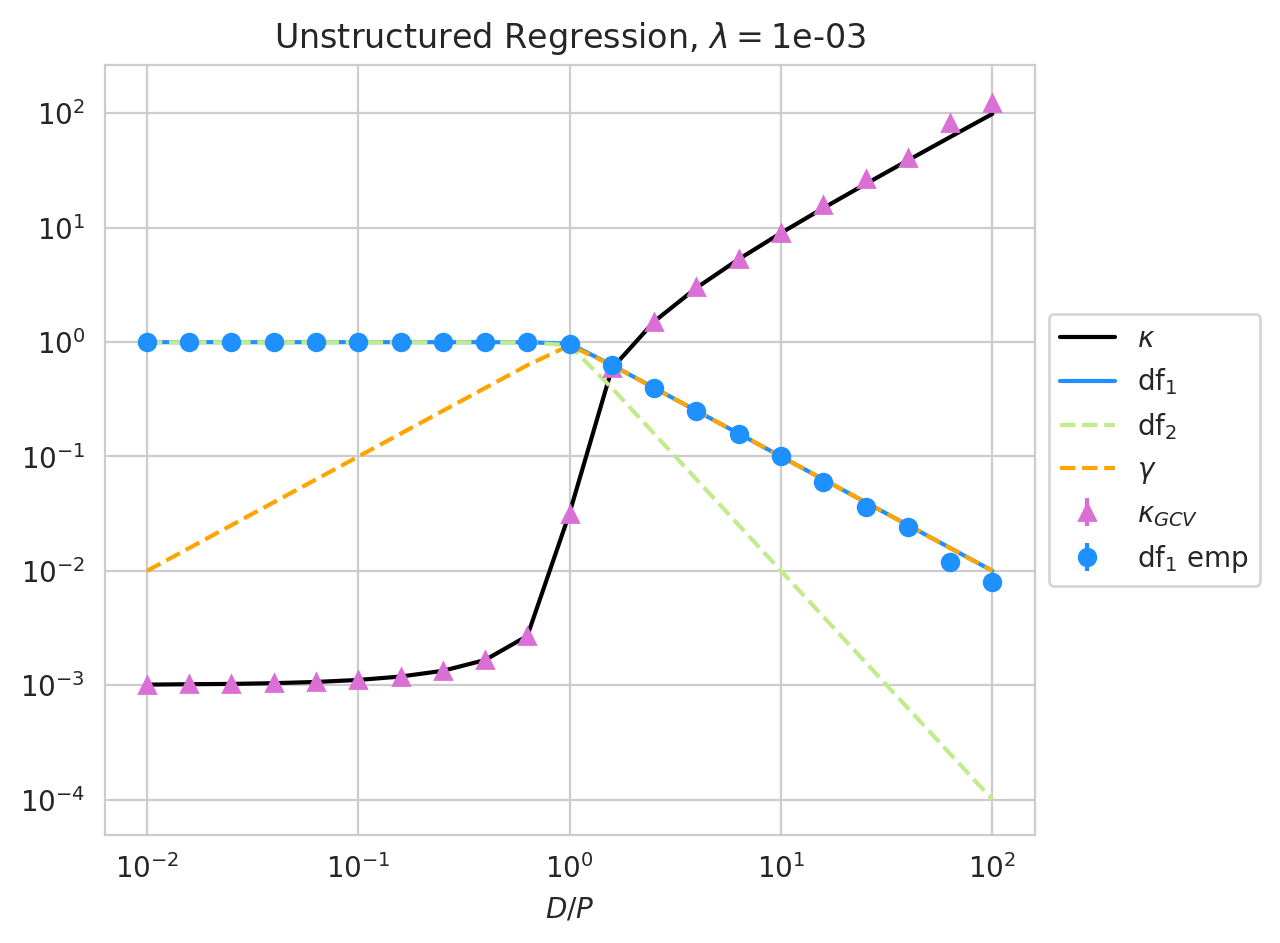

In [16]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, thry['kappa'], label="$\\kappa$", c='k')
plt.errorbar(qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(qs2, thry['df1'], label="df$_1$", c='dodgerblue')
plt.errorbar(qs2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1$ emp", c='dodgerblue')
plt.plot(qs2, thry['df2'], label="df$_2$", c='C4', ls='--')
plt.plot(qs2, thry['gamma'], label="$\\gamma$", c='orange', ls='--')


# plt.plot(qs, thry['S'], c='forestgreen', label="$S$")
# plt.errorbar(qs, expt['kappa_GCV']/lamb, expt['kappa_GCV_std']/lamb, marker='o', linestyle='', c='forestgreen', label='$S$ emp')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$D/P$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
plt.savefig('figures/unstructured_LR_params.pdf', bbox_inches='tight')

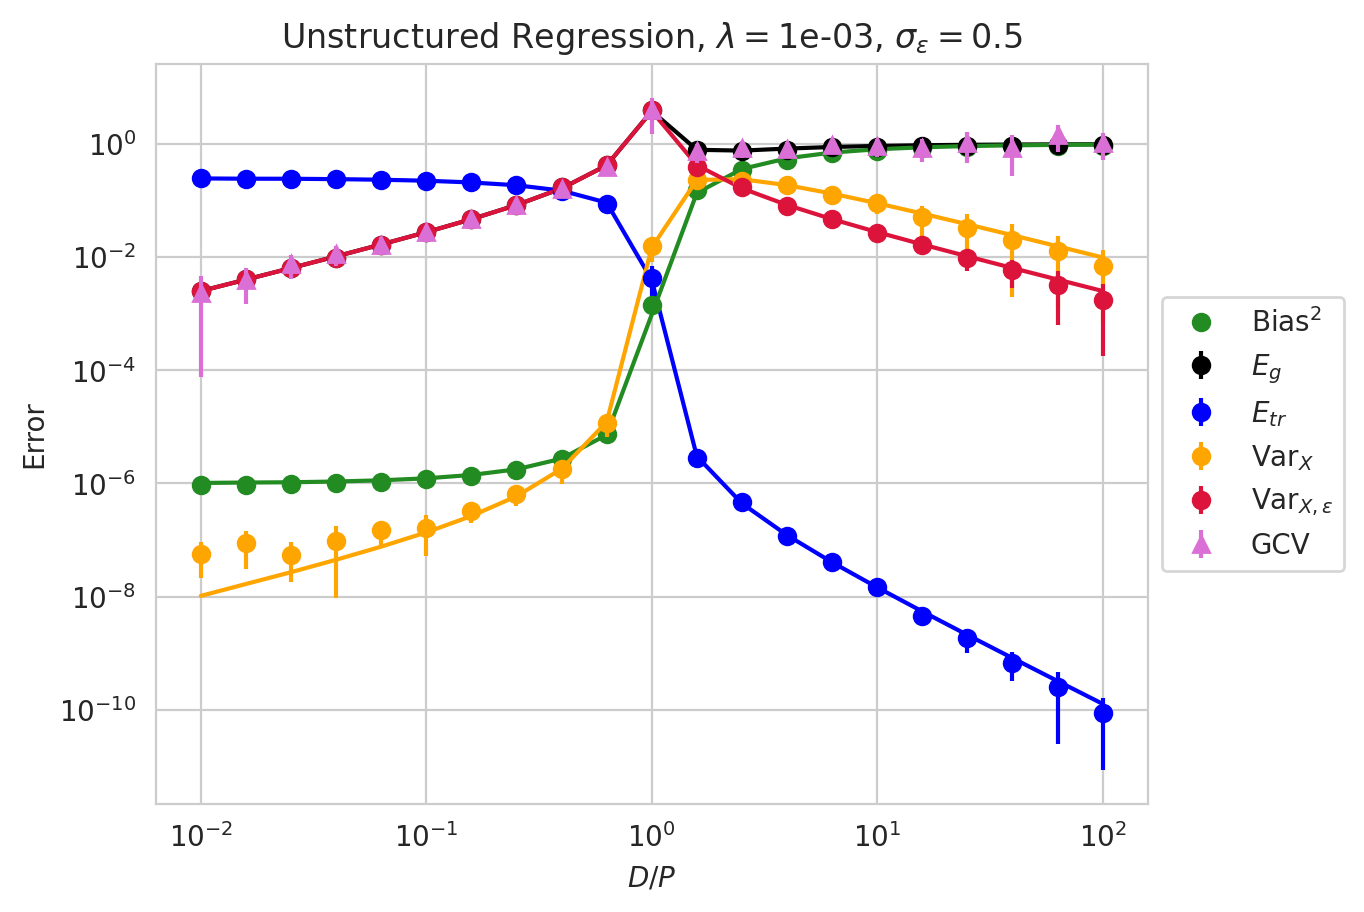

In [12]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarXe']
colors = ['k', 'b', 'forestgreen', 'orange', 'crimson']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(qs, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV/2, E_GCV_std)
plt.errorbar(qs, E_GCV,  E_GCV_std, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$D/P$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-7, 1e1)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig
plt.savefig('figures/unstructured_LR_logspace.pdf', bbox_inches='tight')

In [13]:
qs =  1/np.linspace(0.1, 2.0, 20)
qs2 = 1/np.linspace(0.05, 2.0, 40)
expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)  
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w)

100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


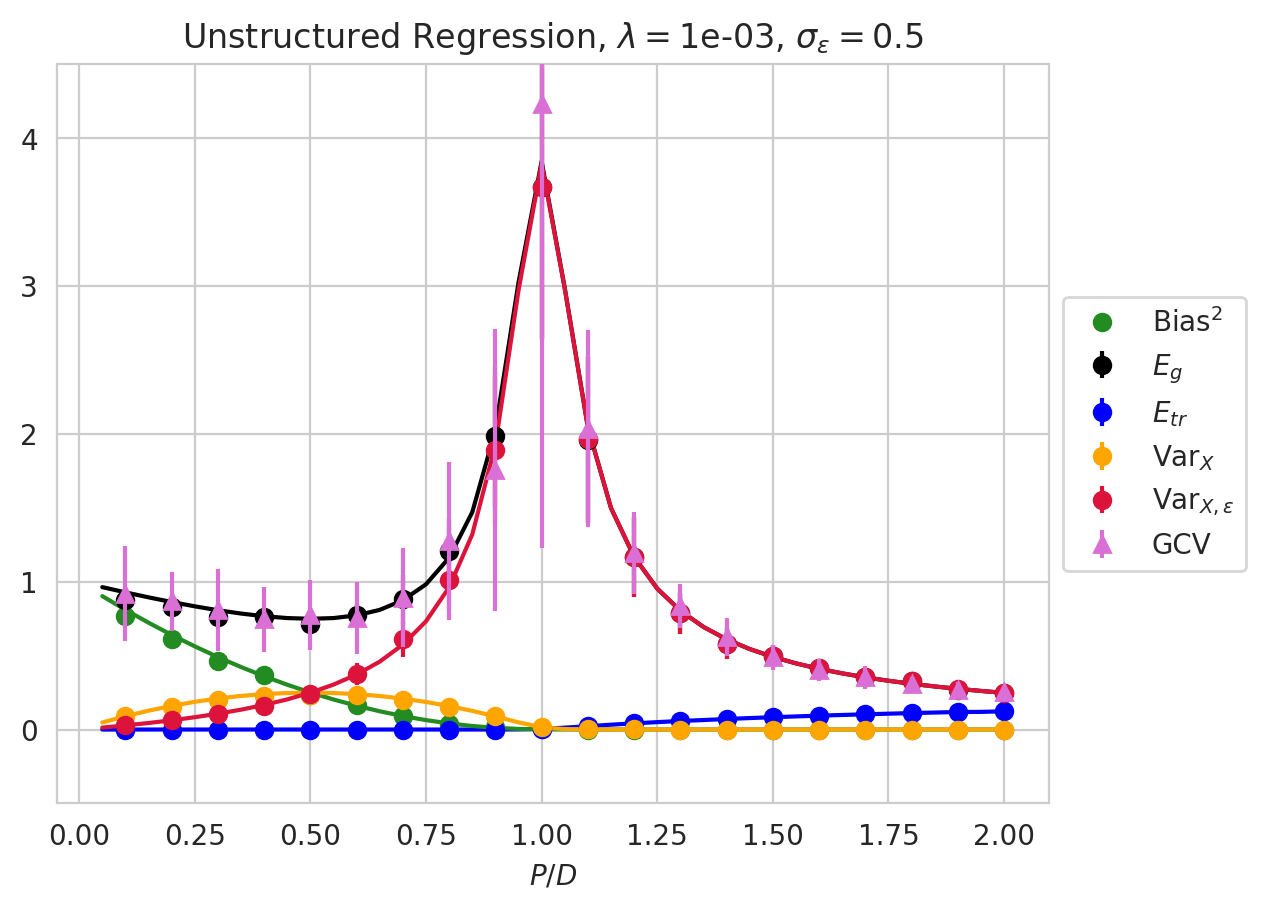

In [14]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarXe']
colors = ['k', 'b', 'forestgreen', 'orange', 'crimson']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], expt[key+'_std'], c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

plt.errorbar(1/qs, (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2, (expt['kappa_GCV']/lamb)**2 * expt['Etr_std'], c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$P/D$')
plt.ylim(-0.5, 4.5)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/unstructured_LR_linspace.pdf', bbox_inches='tight')

## Structured Linear Regression

In [40]:
D = 10_000
num_seeds = 30

qs = np.logspace(1, 4, 20)
qs2 = qs

b = 2.0
a = 4.0

sigma_epsilon = 0.0
lamb = 1e-4
etas = jnp.arange(1, D+1)**(-b)
S = jnp.diag(etas)
w = jnp.arange(1, D+1)**(-(a-b)/2)
w = w / jnp.sqrt(jnp.sum(w**2))

P_te = 200
X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(S)
y_te = X_te @ w

expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)  
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=4)

100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


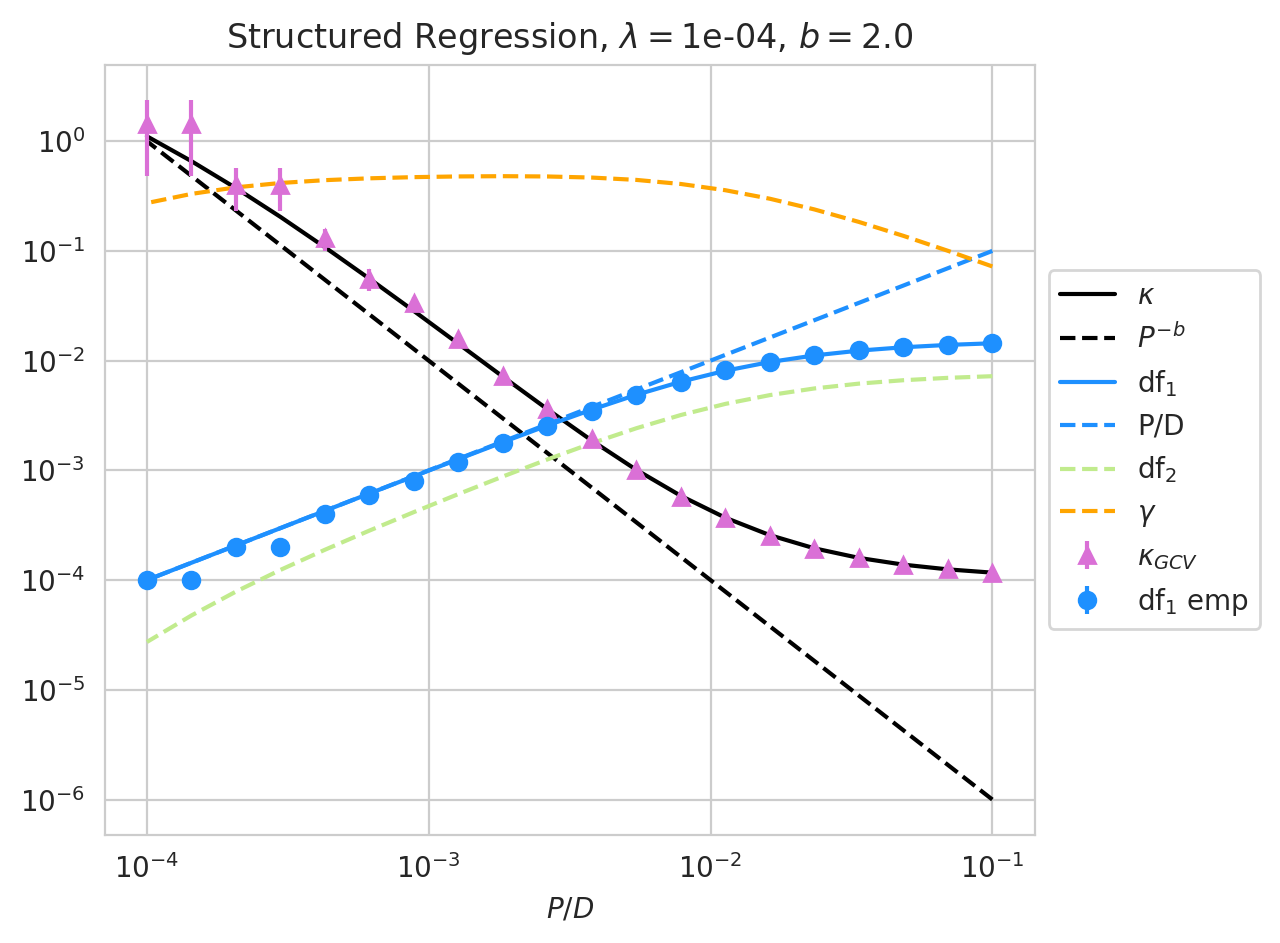

In [43]:
plt.figure(figsize=(6, 5))
plt.plot(1/qs2, thry['kappa'], label="$\\kappa$", c='k')
plt.plot(1/qs2, 1e0*(qs2/D)**(b), c='black', linestyle='--', label='$P^{{-b}}$')

plt.errorbar(1/qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")
plt.plot(1/qs2, thry['df1'], label="df$_1$", c='dodgerblue')
plt.plot(1/qs2, 1/qs2, label="P/D", c='dodgerblue', ls='--')
plt.errorbar(1/qs2, expt['df1'], expt['df1_std'], marker='o', linestyle="", label="df$_1$ emp", c='dodgerblue')
plt.plot(1/qs2, thry['df2'], label="df$_2$", c='C4', ls='--')
plt.plot(1/qs2, thry['gamma'], label="$\\gamma$", c='orange', ls='--')

# plt.plot(qs, thry['S'], c='forestgreen', label="$S$")
# plt.errorbar(qs, expt['kappa_GCV']/lamb, expt['kappa_GCV_std']/lamb, marker='o', linestyle='', c='forestgreen', label='$S$ emp')





plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P/D$')
plt.title(f"Structured Regression, $\\lambda=${lamb:.0e}, $b=${b}")
plt.savefig('figures/structured_LR_params2.pdf', bbox_inches='tight')

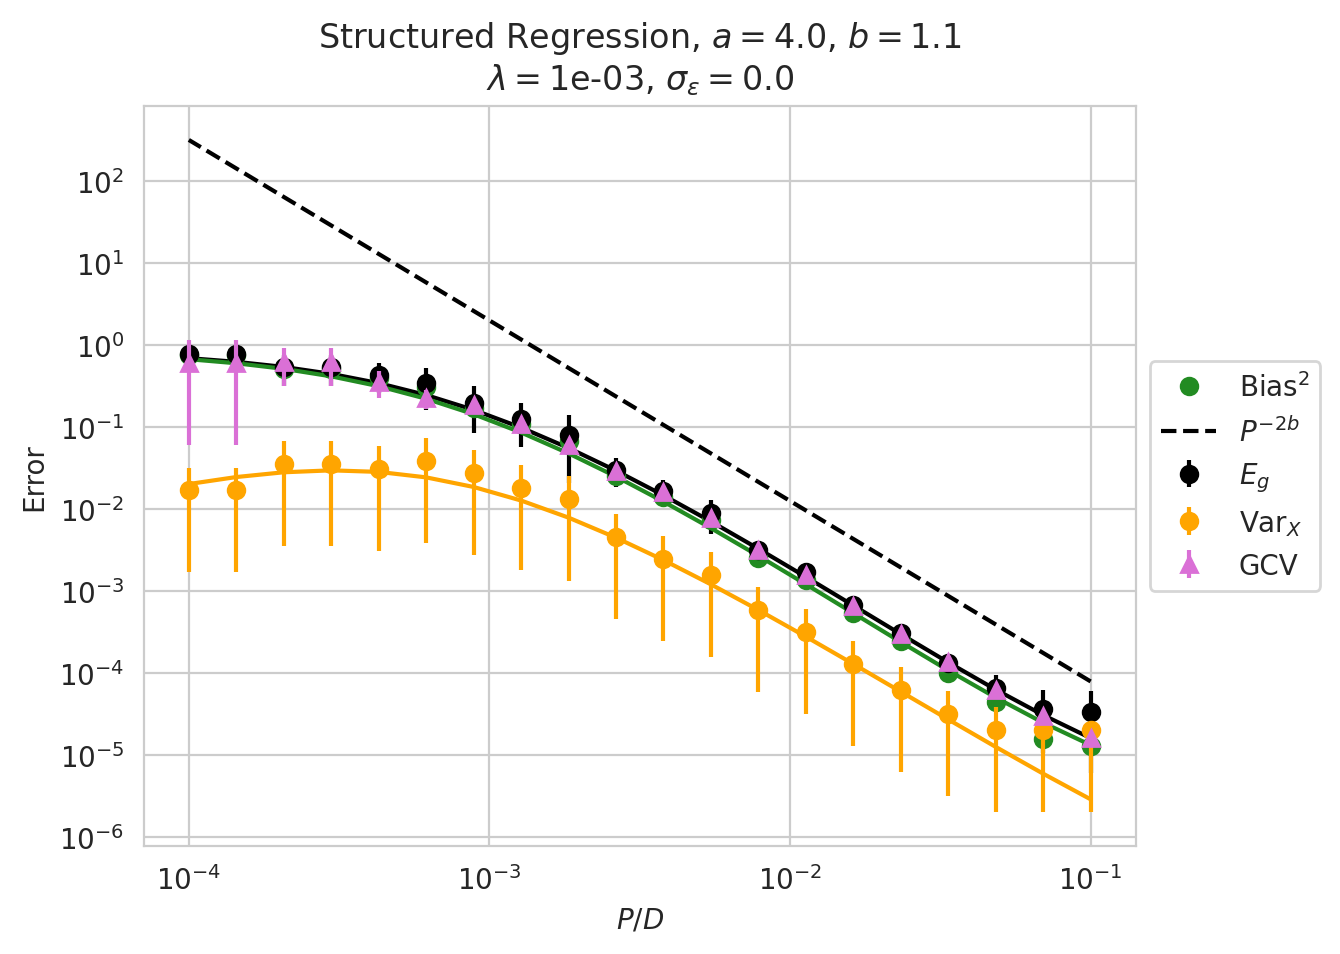

In [123]:
keys = ['Eg', 'Bias', 'VarX']
colors = ['k',  'forestgreen', 'orange']
labels = ["$E_g$", "Bias$^2$", "Var$_X$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

Eg_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
S = expt['kappa_GCV']/lamb
plt.errorbar(1/qs, S**2 * expt['Etr'] - sigma_epsilon**2, np.minimum(S**2 * expt['Etr_std'], 0.9*Eg_GCV), c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.plot(1/qs2, 5e-7*(qs2)**(2*b), c='black', linestyle='--', label='$P^{{-2b}}$')

plt.xlabel(r'$P/D$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(8e-5, 8e-2)
plt.title(f"Structured Regression, $a=${a}, $b=${b}\n$\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/structured_LR_b.pdf', bbox_inches='tight')

## Gapped Linear Regression

In [69]:
D = 10_000

qs = np.logspace(1, 4, 20)
Ps = D/qs
qs2 = qs

b = 0
a = 0
num_seeds = 30

sigma_epsilon = 0.0
lamb = 1e-8
D1 = 10
D2 = 100
D3 = D-D1-D2
e1, e2, e3 = 1e0, 1e-2, 1e-5
w1, w2, w3 = 1, 1e1, 1e2
etas = np.array([e1]*D1 + [e2]*D2 + [e3]*D3) 
S = jnp.diag(etas)
w = np.array([w1]*D1 + [w2]*D2 + [w3]*D3)
w = 1e2 * w / jnp.sqrt(jnp.sum(w**2))

P_te = 200
X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(S)
y_te = X_te @ w

expt = simulate_theory(D, qs, lamb, sigma_epsilon, etas, w, X_te, y_te, num_seeds)  
thry = solve_theory(qs2, lamb, sigma_epsilon, etas, w, anneal_steps=2)

100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


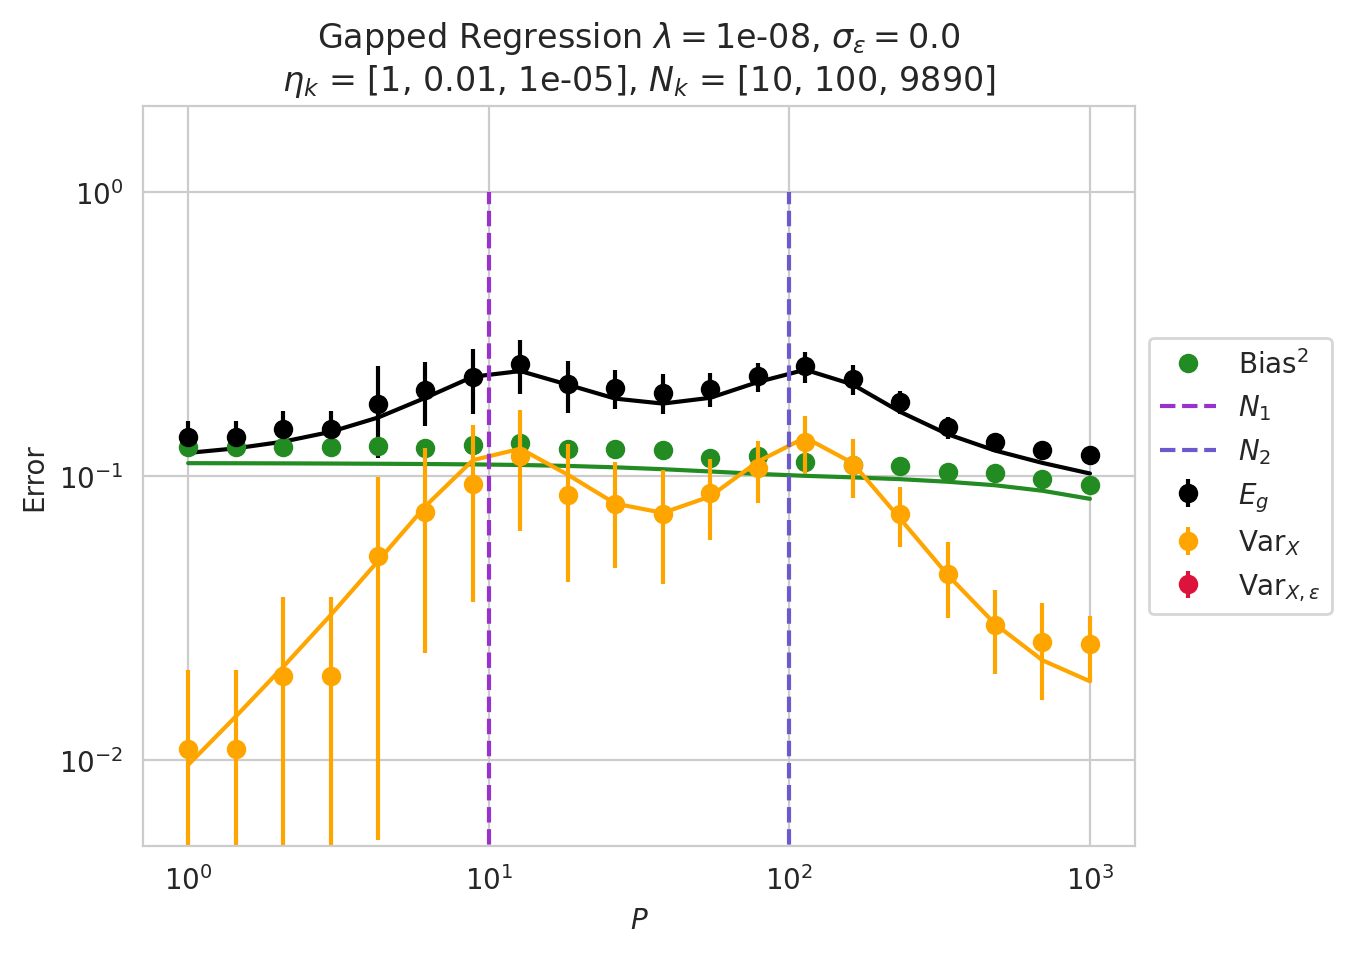

In [87]:
keys = ['Eg',  'Bias', 'VarX', 'VarXe']
colors = ['k',  'forestgreen', 'orange', 'crimson']
labels = ["$E_g$", "Bias$^2$", "Var$_X$", "Var$_{{X, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(D/qs, expt[key], np.minimum(expt[key+'_std'], 0.9*expt[key]), c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(D/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(D/qs2, thry[key], c=color)


plt.plot([D1, D1], [0, 1], c='darkorchid', ls='--', label="$N_1$")
plt.plot([D2, D2], [0, 1], c='slateblue', ls='--', label="$N_2$")
plt.plot(D/qs, (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2 , c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$P$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-3, 2e0)
plt.title(f"Gapped Regression $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}\n$\eta_k$ = [{e1:.0g}, {e2:.0g}, {e3:.0g}], $N_k$ = [{D1}, {D2}, {D3}]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/multiple_descent.pdf', bbox_inches='tight')